In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, PReLU, Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML
from keras.models import load_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### iterate through the folders to create a dataframe of the form filepaths labels

In [3]:

sdir=r'/content/drive/MyDrive/colab/keras/data20200517/rst_classify_data'
filepaths=[]
labels=[]
class_list=os.listdir(sdir)
for klass in class_list:
    class_path=os.path.join(sdir,klass)
    flist=os.listdir(class_path)    
    for f in flist:
        fpath=os.path.join(class_path,f)
        filepaths.append(fpath)
        labels.append(klass)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths labels
0  /content/drive/MyDrive/colab/keras/data2020051...      1
1  /content/drive/MyDrive/colab/keras/data2020051...      1
2  /content/drive/MyDrive/colab/keras/data2020051...      1
3  /content/drive/MyDrive/colab/keras/data2020051...      1
4  /content/drive/MyDrive/colab/keras/data2020051...      1
21    182
16    179
19    179
8     179
18    179
17    179
4     179
3     179
10    179
12    179
5     179
11    179
22    179
15    179
14    179
6     179
7     179
13    179
20    178
9     178
2     178
1     169
X     152
Y      28
Name: labels, dtype: int64


### data set unbalanced - use class weights in model.fit to help with this

In [4]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  3286   test_df length:  411   valid_df length:  411


### create train, test, valid  generators

In [5]:
height=224
width=224
channels=3
batch_size=40
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=batch_size],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1
gen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=gen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=gen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)

test batch size:  3   test steps:  137
Found 3286 validated image filenames belonging to 24 classes.
Found 411 validated image filenames belonging to 24 classes.
Found 411 validated image filenames belonging to 24 classes.
['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '3', '4', '5', '6', '7', '8', '9', 'X', 'Y']


###   determine the class_weight dictionary based on the training set samples per class

In [6]:
class_weight={}
train_dict=train_gen.class_indices
classes=list(train_dict.keys())
train_files=train_gen.filenames
train_labels=train_gen.labels
class_count=len(classes)
print ('length train files: ', len(train_files), '  number of classes: ', class_count)
train_dir=os.path.join(sdir, 'train')
msg='{0:^30s}{1:^10s}{2:^9s}'.format('Class', 'Samples', 'Weight')
print(msg)
balance=train_df['labels'].value_counts()
print (balance)
balance_df=pd.DataFrame(balance)
print (balance_df.head())
for i, count in enumerate(balance_df['labels']):
    class_weight[i]=152/count
print (class_weight)
    

length train files:  3286   number of classes:  24
            Class              Samples   Weight  
15    152
2     152
4     151
19    147
8     147
18    147
9     147
13    146
14    144
21    144
7     143
1     143
12    142
11    142
22    142
6     142
16    141
10    139
17    138
20    137
5     135
3     127
X     120
Y      18
Name: labels, dtype: int64
    labels
15     152
2      152
4      151
19     147
8      147
{0: 1.0, 1: 1.0, 2: 1.0066225165562914, 3: 1.034013605442177, 4: 1.034013605442177, 5: 1.034013605442177, 6: 1.034013605442177, 7: 1.0410958904109588, 8: 1.0555555555555556, 9: 1.0555555555555556, 10: 1.062937062937063, 11: 1.062937062937063, 12: 1.0704225352112675, 13: 1.0704225352112675, 14: 1.0704225352112675, 15: 1.0704225352112675, 16: 1.0780141843971631, 17: 1.0935251798561152, 18: 1.1014492753623188, 19: 1.1094890510948905, 20: 1.125925925925926, 21: 1.1968503937007875, 22: 1.2666666666666666, 23: 8.444444444444445}


### create function to show some image examples

In [7]:
def show_image_samples(gen ):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

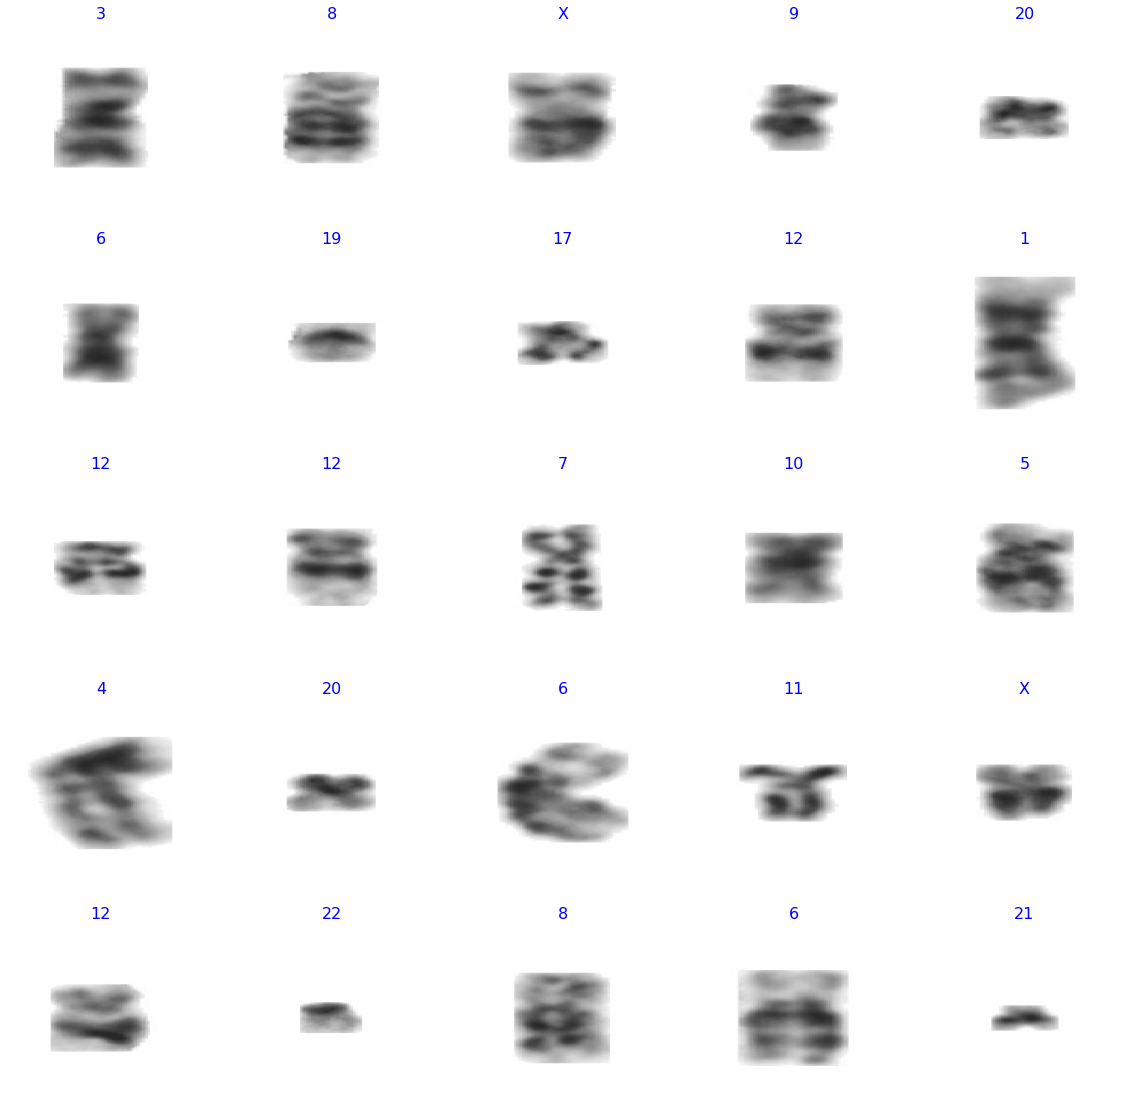

In [8]:
show_image_samples(train_gen)

### define function to print text in RGB foreground and background colors

In [9]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

### create a subclass of callbacks to control learning rate and print training results for each epoch

In [10]:
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    tepochs=0
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze, initial_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        #self.count=0 # initialize counter that counts epochs with no improvement
        #self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement  
        self.initial_epoch=initial_epoch 
        #self.epochs=epochs
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed        
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '            
        print_in_color (msgs, (244, 252, 3), (55,65,80)) 
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now        
        if epoch== self.initial_epoch or LRA.reset==True:  
            LRA.reset=False           
            msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^11s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy','V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
            print_in_color(msg, (244,252,3), (55,65,80)) 
            
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1:
                    color=(245, 170, 66)
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)
                self.lr=lr
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    color=(245, 170, 66)
                    self.lr=self.lr * self.factor # adjust the learning rate
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(LRA.tepochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,0), (55,65,80))
            self.model.stop_training = True # stop training

### define function to plot the training data

In [11]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


### instantiate the custom callback and train the model

### define function to generate the confusion matrix and classification report

In [12]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

### evaluate model on the test set then save the model

### create the model

43941888/43941136 [==============================] - 1s 0us/step
 Starting training using base model EfficientNetB3 training all layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR   Monitor  Duration

 1 /500   10.360   24.376  10.13365   5.109   0.00100  0.00100  accuracy  1975.64 

 2 /500    7.812   62.386   9.85009   5.109   0.00100  0.00100  accuracy   112.06 

 3 /500    6.452   81.771   8.61945   9.246   0.00100  0.00100  accuracy   112.20 

 4 /500    5.613   87.979   8.06378   8.516   0.00100  0.00100  accuracy   112.20 

 5 /500    4.918   92.088   7.33482   7.299   0.00100  0.00100  val_loss   112.16 

 6 /500    4.336   94.218   6.71364   7.056   0.00100  0.00100  val_loss   112.23 

 7 /500    3.795   96.105   6.02012  21.411   0.00100  0.00100  val_loss   112.18 

 8 /500    3.330   97.261   6.06357  12.165   0.00100  0.00050  val_loss   112.04 

 9 /500    3.421   97.079   5.88048  17.518   0.00050  0.00050  val_loss   112.32 

10 /500    3.181   97.

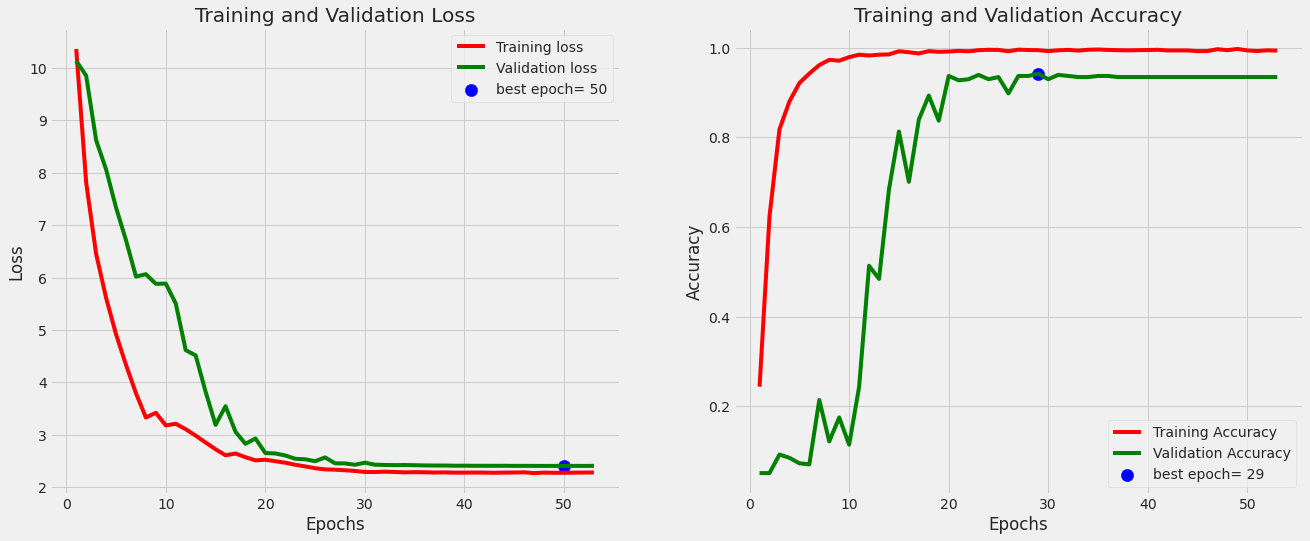

137/137 [==============================] - 220s 2s/step - loss: 2.4461 - accuracy: 0.9392
accuracy on the test set is 93.92 %



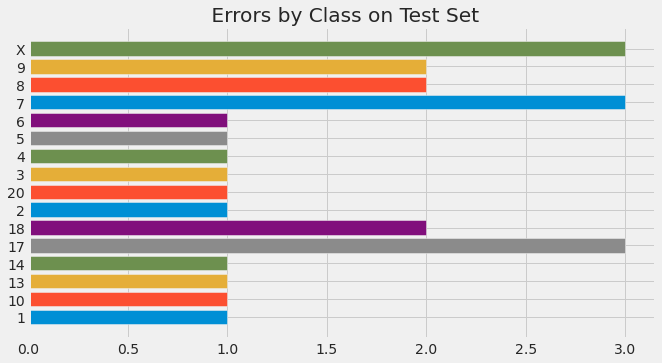

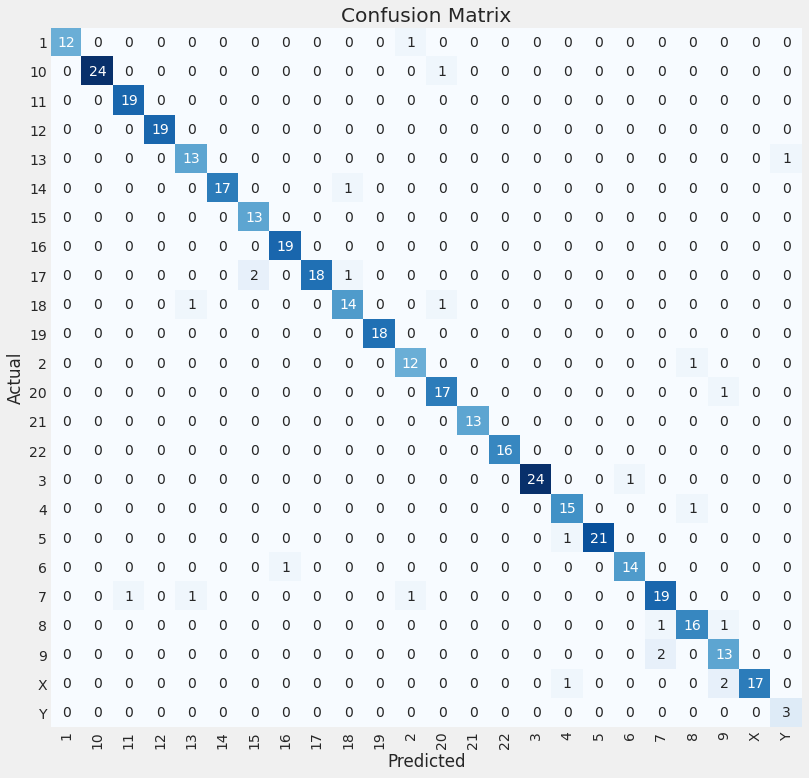

Classification Report:
----------------------
               precision    recall  f1-score   support

           1       1.00      0.92      0.96        13
          10       1.00      0.96      0.98        25
          11       0.95      1.00      0.97        19
          12       1.00      1.00      1.00        19
          13       0.87      0.93      0.90        14
          14       1.00      0.94      0.97        18
          15       0.87      1.00      0.93        13
          16       0.95      1.00      0.97        19
          17       1.00      0.86      0.92        21
          18       0.88      0.88      0.88        16
          19       1.00      1.00      1.00        18
           2       0.86      0.92      0.89        13
          20       0.89      0.94      0.92        18
          21       1.00      1.00      1.00        13
          22       1.00      1.00      1.00        16
           3       1.00      0.96      0.98        25
           4       0.88      0.94 

In [13]:
epochs =500
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
save_dir=r'/content/drive/MyDrive/colab/keras/data20200517/WeightsforModelEnsemble/EfficientNetB3'
subject='rst'

model_name1='EfficientNetB3'
base_model1=tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model1.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output1=Dense(class_count, activation='softmax')(x)
model1=Model(inputs=base_model1.input, outputs=output1)
model1.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks1=[LRA(model=model1,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_name1, freeze=freeze, initial_epoch=0 )]
LRA.tepochs=epochs  # used to determine value of last epoch for printing
history1=model1.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks1,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0, class_weight=class_weight)
tr_plot(history1,0)
acc1=model1.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg1=f'accuracy on the test set is {acc1:5.2f} %'
print_in_color(msg1, (0,255,0),(55,65,80))
save_id1=str (model_name1 + '.h5')
save_loc1=os.path.join(save_dir, save_id1)
model1.save(save_loc1)
print_code=0
preds1=model1.predict(test_gen) 
print_info( test_gen, preds1, print_code, save_dir, subject )

# Concatenate Model

In [16]:
import numpy as np
# load pre-trained ensemble members
n_members = 3
models = list()
for i in range(n_members):
	# load model
  if i == 0:
	  filename = '/content/drive/MyDrive/colab/keras/data20200517/WeightsforModelEnsemble/' + 'DenseNet121' + '.h5'
  if i == 1:
    filename = '/content/drive/MyDrive/colab/keras/data20200517/WeightsforModelEnsemble/' + 'ResNet50' + '.h5'
  if i == 2:
    filename = save_dir + '/EfficientNetB3' + '.h5'
  model = load_model(filename)
  models.append(model)

# make predictions
yhats = [model.predict(test_gen) for model in models]
yhats = np.array(yhats)
# sum across ensembles
summed = np.sum(yhats, axis=0)
# argmax across classes
outcomes = np.argmax(summed, axis=1)

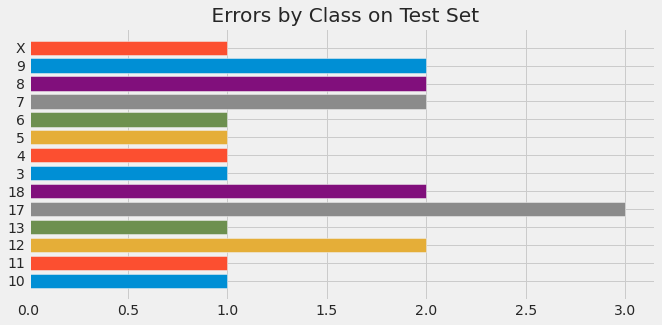

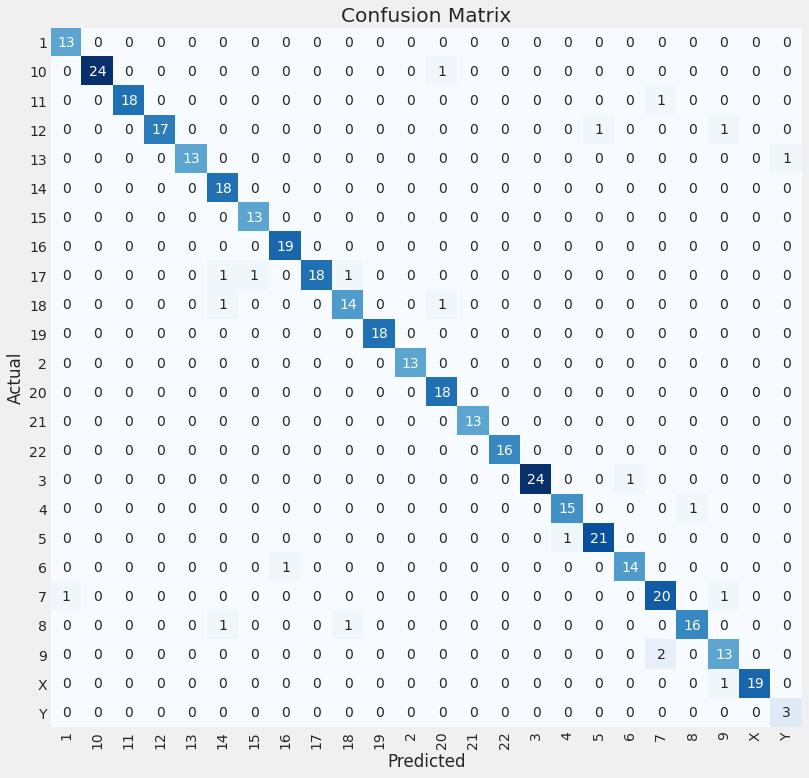

Classification Report:
----------------------
               precision    recall  f1-score   support

           1       0.93      1.00      0.96        13
          10       1.00      0.96      0.98        25
          11       1.00      0.95      0.97        19
          12       1.00      0.89      0.94        19
          13       1.00      0.93      0.96        14
          14       0.86      1.00      0.92        18
          15       0.93      1.00      0.96        13
          16       0.95      1.00      0.97        19
          17       1.00      0.86      0.92        21
          18       0.88      0.88      0.88        16
          19       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        13
          20       0.90      1.00      0.95        18
          21       1.00      1.00      1.00        13
          22       1.00      1.00      1.00        16
           3       1.00      0.96      0.98        25
           4       0.94      0.94 

In [17]:
print_info( test_gen, summed, print_code, save_dir, subject )